In [281]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import ttest_ind
import statsmodels.stats.power as smp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

We load the datasets and extract only the relavant columns that we decided upon in 1st part of this project

In [282]:
df_processes=pd.read_csv("data/processes.csv",sep='\t')
df_connections = pd.read_csv("data/connections.csv", sep='\t')
df_connections=df_connections[df_connections.columns[2:8]]
df_processes=df_processes[['mwra','p.android.gm','p.android.settings','p.system','p.android.externalstorage','p.android.documentsui']]
df_processes.head()

,mwra,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
0,0.0,11.14770,10.34567,14.24441,11.51584,13.85827
1,1.0,9.51907,8.97598,16.31514,10.40542,13.02322
2,1.0,13.15840,12.78871,18.05368,11.57740,15.33671
3,0.0,11.61736,9.20242,9.84154,11.75419,11.43078
4,0.0,13.19246,15.48980,14.67672,12.62410,14.81432


We split the data into 2 dataframes in ratio o 8/2 ( standart data spliting ratios )

In [283]:

df_processes, df_processes_test = train_test_split(df_processes, test_size=0.2, random_state=42)
print(df_processes.shape,df_processes_test.shape)

(12109, 6) (3028, 6)


We do the same for df_connections

In [284]:
df_connections, df_connections_test = train_test_split(df_connections, test_size=0.2, random_state=42)
print(df_connections.shape,df_connections_test.shape)


(12109, 6) (3028, 6)


Display the data for better visualization

<Axes: >

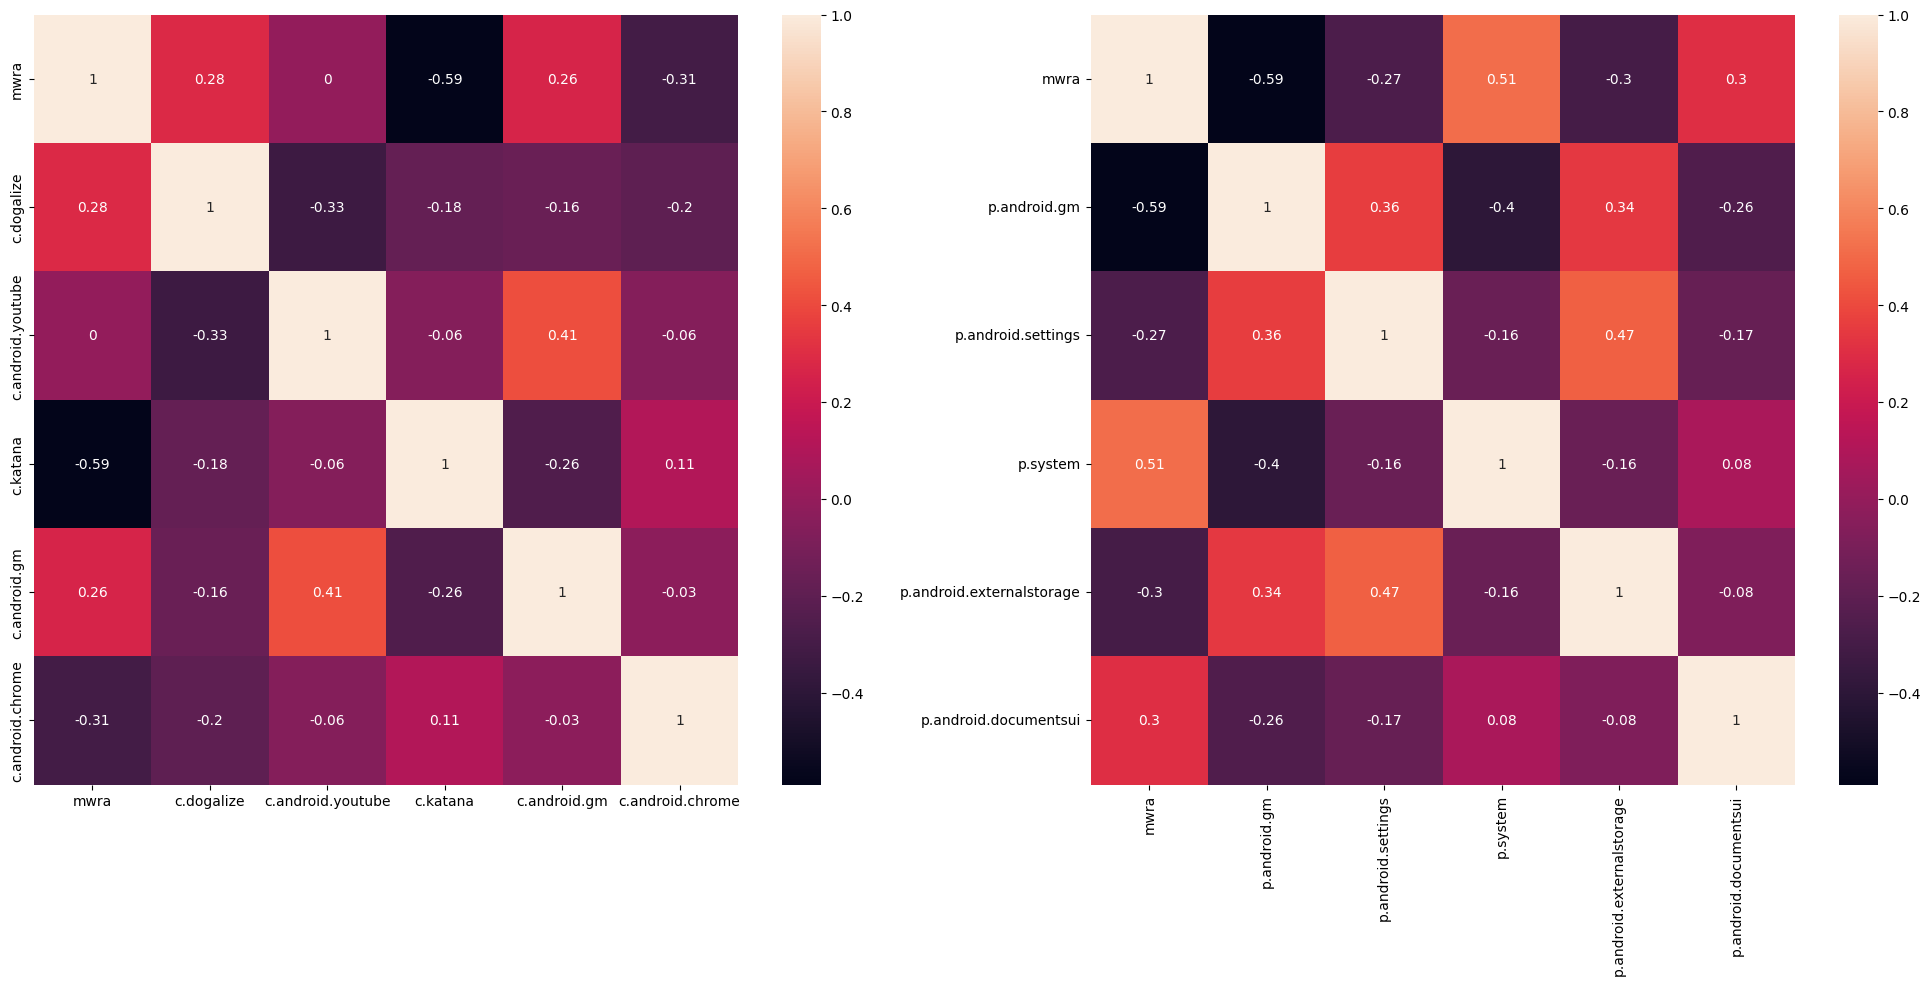

In [285]:
plt.figure(figsize=(25,10))
df_connections.drop_duplicates(inplace=True)
plt.subplot(1,2,1)
sns.heatmap(df_connections.iloc[:,:].corr().round(decimals=2),annot=True)

df_processes.drop_duplicates(inplace=True)
plt.subplot(1,2,2)
sns.heatmap(df_processes.iloc[:,:].corr().round(decimals=2),annot=True)


2.1 First we start by removing outlier

In [286]:
df_processes.describe()

,mwra,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000
mean,0.625094,12.222030,13.360591,13.316416,13.388931,13.906858
std,0.484119,2.420685,2.621391,2.776730,2.466921,2.468071
min,0.000000,3.492160,2.936040,2.605000,4.020180,5.614740
25%,0.000000,10.456085,11.699365,11.346090,11.804665,12.225840
50%,1.000000,11.997270,13.651800,13.339480,13.674850,14.006630
75%,1.000000,13.950395,15.199545,15.321490,15.154060,15.614400
max,1.000000,21.005110,21.756040,23.130130,23.066440,22.530620


for loop will iterate over every column and remove_outlier function will with help of identify_outlier then remove the outlier of said column by replacing it with its nearest quantile

In [287]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return (a > upper) | (a < lower)

def remove_outlier(df,column):
    outlier_mask = identify_outliers(df[column])
    lower_bound = df[column].quantile(0.05)
    upper_bound = df[column].quantile(0.95)
    df.loc[outlier_mask, column] = np.where(
        df.loc[outlier_mask, column] < lower_bound,
        lower_bound,
        upper_bound
    )
    return df

for column in df_processes.columns:
    df_processes=remove_outlier(df_processes,column)
df_processes.describe()

,mwra,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000
mean,0.625094,12.219616,13.379864,13.318666,13.404879,13.905280
std,0.484119,2.403120,2.558275,2.761312,2.410490,2.436854
min,0.000000,5.301570,6.455370,5.403180,6.781000,7.203720
25%,0.000000,10.456085,11.699365,11.346090,11.804665,12.225840
50%,1.000000,11.997270,13.651800,13.339480,13.674850,14.006630
75%,1.000000,13.950395,15.199545,15.321490,15.154060,15.614400
max,1.000000,19.187440,20.431470,21.267890,20.166420,20.681910


As can be observed , compared to the first df_connectoins.describe() the max/min values are way less extreme making it better suitable for ML

In [288]:
df_connections.describe()

,mwra,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome
count,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000
mean,0.625094,12.153374,12.752353,12.208188,12.121103,11.557645
std,0.484119,2.625899,2.685466,2.432228,2.763639,2.363564
min,0.000000,2.568060,2.890720,2.960460,2.366610,0.000000
25%,0.000000,10.297690,10.826245,10.416540,10.187660,9.917270
50%,1.000000,12.044410,12.867380,11.986450,11.955090,11.405390
75%,1.000000,13.998020,14.732575,14.021170,13.924070,13.086745
max,1.000000,21.997370,21.386740,22.398300,22.667660,20.538700


We reuse the function used above to do the same with df_connections

In [289]:
for column in df_connections.columns:
    df_connections=remove_outlier(df_connections,column)
df_connections.describe()

,mwra,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome
count,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000
mean,0.625094,12.152915,12.758038,12.202676,12.109756,11.550961
std,0.484119,2.604130,2.664888,2.409126,2.710240,2.306092
min,0.000000,4.789020,4.991870,5.127470,4.622840,5.217290
25%,0.000000,10.297690,10.826245,10.416540,10.187660,9.917270
50%,1.000000,12.044410,12.867380,11.986450,11.955090,11.405390
75%,1.000000,13.998020,14.732575,14.021170,13.924070,13.086745
max,1.000000,19.514050,20.556610,19.385140,19.527540,17.839290


2.1.C Transforming and Scaling the data

Next we want to Scale the data . 

We decided on using RobustScaler because it uses median and IQR, also because it's less affected by skewness and is very reliable in producing stable scaled output.

Since we were tasked with using 2 scalers we decided on using MinMaxScaler because it can produce pretty much same result as RobustScaler making it more readable for humans and machines.



In here we created scale_data function that takes as arguments the dataframe , high_std_columns and low_std_columns . We didn't know how to choose which data to pick for which scaler that's why we decided to use std as value that decides. columns with std higher than 2.5 will be scaled by RobustScaler and columns with std bigger than 1 but lower than 2.5 will be scaled by MinMaxScaler to value bettwen 0 and 2 . In the function we first save the the mwra column to it's own variable and drop it from main df because it would cause problems in ColumnTransformer and shift the column values around. Next we create ColumnTransformer which has MinMaxScaler and RobustScaler inside of it where MinMaxScaler takes as argument low_std and RobustScaler takes high_std. Pipeline is then created and then the data is passed into the pipeline to scale the data and lastly we add the mwra back inside

In [290]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
def scale_data(df, high_std_columns, low_std_columns):
    mwra = df[['mwra']]
    df_transformed = df.drop(columns=['mwra'])

    # Define transformers for low and high std columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('low_std', MinMaxScaler(feature_range=(-2, 2)), low_std_columns),
            ('high_std', RobustScaler(), high_std_columns)
        ],
        remainder='passthrough'
    )
    
    # Create a pipeline with the ColumnTransformer
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    scaled_data = pipeline.fit_transform(df_transformed)
    scaled_df = pd.DataFrame(scaled_data, columns=df_transformed.columns)

    final_df = pd.concat([mwra.reset_index(drop=True), scaled_df.reset_index(drop=True)], axis=1)
    return final_df[df.columns]
# we devide the tables 
std_devs = df_connections.std()
high_std_columns_connections = std_devs[std_devs > 2.5].index
low_std_columns_connections = std_devs[(std_devs > 1) & (std_devs <= 2.5)].index
#we save this distribution and use it later for testing data as well
print("columns with std lower than 2.5 = "+low_std_columns_connections)
print("columns with std higher than 2.5 = "+high_std_columns_connections)
df_connections=scale_data(df_connections,high_std_columns_connections, low_std_columns_connections)



Index(['columns with std lower than 2.5 = c.katana', 'columns with std lower than 2.5 = c.android.chrome'], dtype='object')
Index(['columns with std higher than 2.5 = c.dogalize',
       'columns with std higher than 2.5 = c.android.youtube',
       'columns with std higher than 2.5 = c.android.gm'],
      dtype='object')


As can be observed, the values are all in range -2 to 2 

In [291]:
df_connections.describe()

,mwra,c.dogalize,c.android.youtube,c.katana,c.android.gm,c.android.chrome
count,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000
mean,0.625094,-0.015046,0.007185,0.029323,-0.027991,0.041394
std,0.484119,0.675882,0.730817,0.703756,0.682197,0.725359
min,0.000000,-2.000000,-2.000000,-1.960741,-2.016089,-1.962378
25%,0.000000,-0.516147,-0.510543,-0.472044,-0.522520,-0.473029
50%,1.000000,-0.075708,-0.038948,0.000000,0.000000,0.000000
75%,1.000000,0.495134,0.493885,0.527956,0.477480,0.526971
max,1.000000,2.000000,2.000000,2.018642,1.968403,2.026665


array([[<Axes: title={'center': 'c.dogalize'}>,
        <Axes: title={'center': 'c.android.youtube'}>],
       [<Axes: title={'center': 'c.katana'}>,
        <Axes: title={'center': 'c.android.gm'}>],
       [<Axes: title={'center': 'c.android.chrome'}>, <Axes: >]],
      dtype=object)

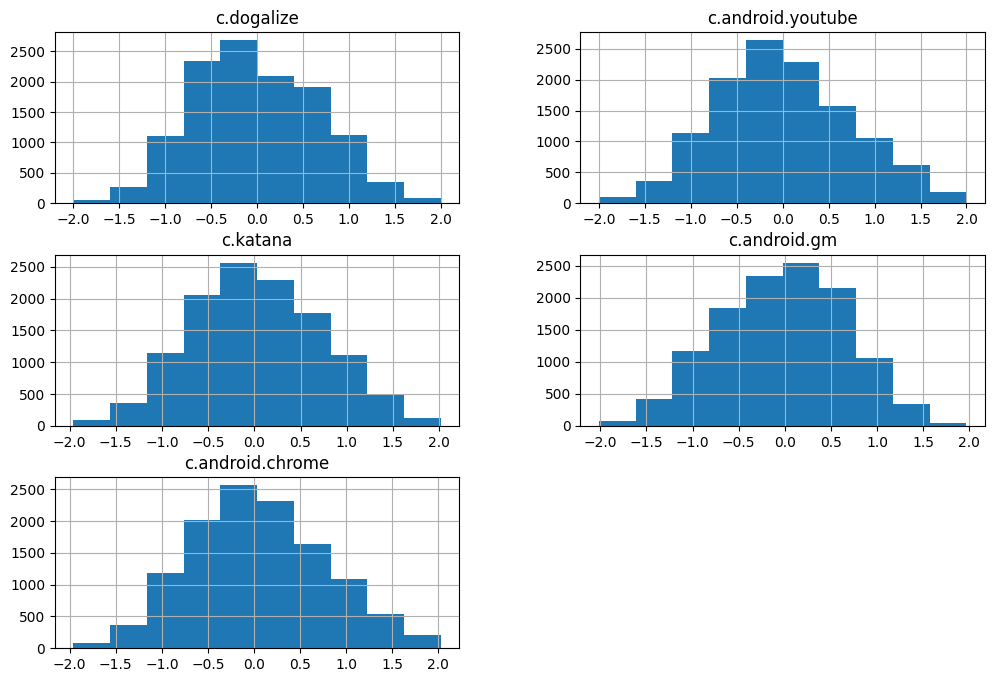

In [292]:
df_connections.hist(column=df_connections.columns[1:],figsize=(12,8))

Next we decided upon using PowerTransformer and QuantileTransformer but first we display data to better observe how the data is changing

array([[<Axes: title={'center': 'p.android.gm'}>,
        <Axes: title={'center': 'p.android.settings'}>],
       [<Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>],
       [<Axes: title={'center': 'p.android.documentsui'}>, <Axes: >]],
      dtype=object)

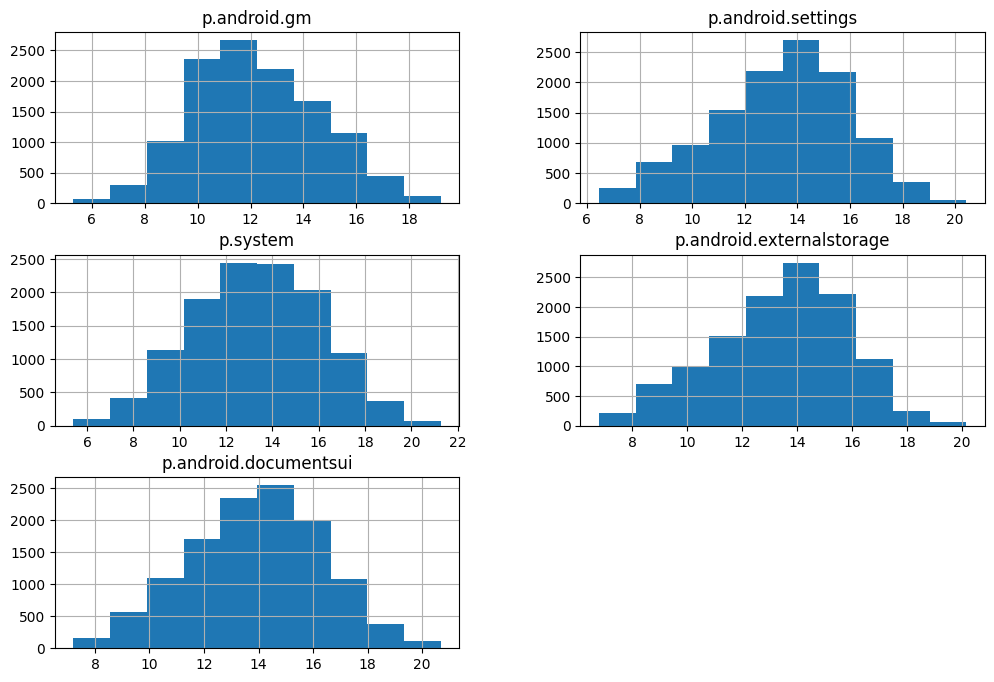

In [294]:
df_processes.hist(column=df_processes.columns[1:],figsize=(12,8))

In [295]:
df_processes.describe()

,mwra,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000,11995.000000
mean,0.625094,12.219616,13.379864,13.318666,13.404879,13.905280
std,0.484119,2.403120,2.558275,2.761312,2.410490,2.436854
min,0.000000,5.301570,6.455370,5.403180,6.781000,7.203720
25%,0.000000,10.456085,11.699365,11.346090,11.804665,12.225840
50%,1.000000,11.997270,13.651800,13.339480,13.674850,14.006630
75%,1.000000,13.950395,15.199545,15.321490,15.154060,15.614400
max,1.000000,19.187440,20.431470,21.267890,20.166420,20.681910


We decided to use PowerTransformer or QuantileTransformer for this task because as we were taught , the normal distribution is helpful in more than few aspects hence achieving gausian like distribution was our goal for this Machine Learning project.


Firstly we devided the data in same way as we did with df_connections . Then by creating function we achived abstraction and reusability for future use . In this function we once again save mwra to it's own column and transform the data using PowerTransformer and QuantileTransformer inside Pipeline . Lastly we concat the data and return them in same order as they were given to us (return final_df[df_processes.columns])


In [296]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer# type: ignore

std_devs = df_processes.std()

high_std_columns_processes = std_devs[std_devs > 2.5].index
low_std_columns_processes = std_devs[(std_devs > 1) & (std_devs <= 2.5)].index
#we make it into a function for better reusability
def transform_data(df,high_std_columns,low_std_columns):

    mwra = df[['mwra']] 
    # We had problems with mwra and pipeline so instead we decided on removing mwra and then appending it afterwards
    df_transformed= df.drop(columns=['mwra'])
    #column transformer for specified Transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('low_std', PowerTransformer(method='box-cox'), low_std_columns_processes),
            ('high_std', QuantileTransformer(output_distribution='normal'), high_std_columns_processes)
        ],
        remainder='passthrough'
    )

    #  Create a pipeline with the ColumnTransformer
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    transformed_data = pipeline.fit_transform(df_transformed)
    transformed_df = pd.DataFrame(transformed_data, columns=df_transformed.columns)# convert the data back to df

    #  add 'mwra' back to the front
    final_df = pd.concat([mwra.reset_index(drop=True), transformed_df.reset_index(drop=True)], axis=1)

    # put them back to their original order
    return final_df[df_processes.columns]
df_processes=transform_data(df_processes,high_std_columns_processes,low_std_columns_processes)

Clear differences and better , more gausian like results can be observed

array([[<Axes: title={'center': 'p.android.gm'}>,
        <Axes: title={'center': 'p.android.settings'}>],
       [<Axes: title={'center': 'p.system'}>,
        <Axes: title={'center': 'p.android.externalstorage'}>],
       [<Axes: title={'center': 'p.android.documentsui'}>, <Axes: >]],
      dtype=object)

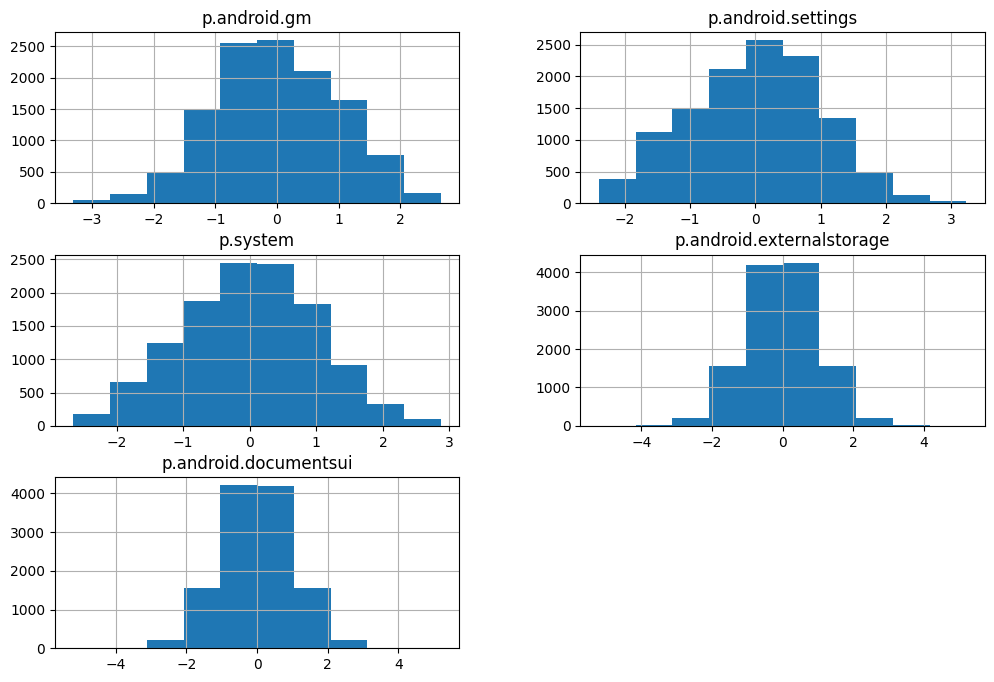

In [297]:
df_processes.hist(column=df_processes.columns[1:],figsize=(12,8))

In [298]:
df_processes.describe()

,mwra,p.android.gm,p.android.settings,p.system,p.android.externalstorage,p.android.documentsui
count,11995.000000,1.199500e+04,1.199500e+04,1.199500e+04,11995.000000,11995.000000
mean,0.625094,1.443595e-15,1.747479e-16,1.806716e-16,0.005322,0.001336
std,0.484119,1.000042e+00,1.000042e+00,1.000042e+00,1.000128,1.002233
min,0.000000,-3.304211e+00,-2.392881e+00,-2.650189e+00,-5.199338,-5.199338
25%,0.000000,-7.136242e-01,-7.094645e-01,-6.985143e-01,-0.664204,-0.675625
50%,1.000000,-5.152715e-02,5.667969e-02,2.778642e-02,0.007380,0.000564
75%,1.000000,7.388760e-01,7.116266e-01,6.961151e-01,0.678414,0.673336
max,1.000000,2.657914e+00,3.231288e+00,2.869803e+00,5.199338,5.199338


In [299]:
cn_train_non = df_connections.drop(columns=['mwra'])
cn_train_mwra = df_connections['mwra']

mi_scores = mutual_info_classif(cn_train_non, cn_train_mwra)
mi_scores_series = pd.Series(mi_scores, index=cn_train_non.columns).sort_values(ascending=False)
print("Mutual Information Scores:\n", mi_scores_series)

Mutual Information Scores:
 c.dogalize           0.218088
c.android.youtube    0.081664
c.katana             0.053757
c.android.chrome     0.044713
c.android.gm         0.001417
dtype: float64


In [300]:
pr_train_non = df_processes.drop(columns=['mwra'])
pr_train_mwra = df_processes['mwra']

mi_scores = mutual_info_classif(pr_train_non, pr_train_mwra)
mi_scores_series = pd.Series(mi_scores, index=pr_train_non.columns).sort_values(ascending=False)
print("Mutual Information Scores:\n", mi_scores_series)

Mutual Information Scores:
 p.android.gm                 0.219726
p.android.documentsui        0.154353
p.android.externalstorage    0.051943
p.system                     0.051904
p.android.settings           0.048466
dtype: float64


In [301]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

selector = SelectKBest(score_func=f_regression, k=3)
Chi_connections = selector.fit_transform(cn_train_non, cn_train_mwra)

feature_scores = selector.scores_
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = [cn_train_non.columns[i] for i in selected_feature_indices]

print("Selected Features:", selected_feature_names)
print("Scores of Selected Features:", feature_scores[selected_feature_indices])

Selected Features: ['c.dogalize', 'c.android.youtube', 'c.katana']
Scores of Selected Features: [6487.4390717  1342.86428168 1014.49990893]


In [302]:
selector = SelectKBest(score_func=f_regression, k=3)
Chi_processes = selector.fit_transform(pr_train_non, pr_train_mwra)

feature_scores = selector.scores_
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = [pr_train_non.columns[i] for i in selected_feature_indices]

print("Selected Features:", selected_feature_names)
print("Scores of Selected Features:", feature_scores[selected_feature_indices])

Selected Features: ['p.android.gm', 'p.system', 'p.android.documentsui']
Scores of Selected Features: [6270.36662474 1195.74331749 4067.62615486]


In [303]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

X = cn_train_non
y = cn_train_mwra

estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

print("Selected features (True indicates selected):", selector.support_)
print("Feature ranking (1 indicates selected features):", selector.ranking_)

Selected features (True indicates selected): [ True  True  True  True  True]
Feature ranking (1 indicates selected features): [1 1 1 1 1]


In [304]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

X = pr_train_non
y = pr_train_mwra

estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

print("Selected features (True indicates selected):", selector.support_)
print("Feature ranking (1 indicates selected features):", selector.ranking_)

Selected features (True indicates selected): [ True  True  True  True  True]
Feature ranking (1 indicates selected features): [1 1 1 1 1]


2.3 we can easily adjust the testing data using the exact same functions /methods we used on the training data (drop duplicats,remove_outlier,scale_data/transform_data). Pipeline was used in scale_data and transform_data